



#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계2 : 모델링

## 0.미션

* 다음 두가지 챗봇을 만들고 비교해 봅시다.
* 챗봇1. Word2Vec 임베딩 벡터 기반 머신러닝 분류 모델링
    * Word2Vec 모델을 만들고 임베딩 벡터를 생성합니다.
    * 임베딩 벡터를 이용하여 intent를 분류하는 모델링을 수행합니다.
        * 이때, LightGBM을 추천하지만, 다른 알고리즘을 이용할수 있습니다.
    * 예측된 intent의 답변 중 임의의 하나를 선정하여 출력합니다.
* 챗봇2. 단계별 모델링1
    * 1단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
    * 2단계 : 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기

* 챗봇3. 단계별 모델링1
    * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
        * Embedding + LSTM 모델링
    * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
    * 3단계 : 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기

* 챗봇 3개에 대해서 몇가지 질문을 입력하고 각각의 답변을 비교해 봅시다.


## 1.환경준비

#### 1) Google Colab 환경 구축

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (1)라이브러리 설치

#### 1) gensim 설치

In [2]:
#gensim은 자연어 처리를 위한 오픈소스 라이브러리입니다. 토픽 모델링, 워드 임베딩 등 다양한 자연어 처리 기능을 제공
!pip install gensim

#### 2) 형태소 분석을 위한 라이브러리

In [3]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
curl is already the newest version (7.81.0-1ubuntu1.14).
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
g++ set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
B

In [4]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
# !pip install mecab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 46.8 MB/s eta 0:00:00


In [5]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,320 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121080 files and dire

### (2) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

import tensorflow as tf
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from keras import Input, Model
from keras import optimizers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import gensim
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
print(font_name)
plt.rcParams['font.family']=font_name
assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

NanumGothic


* 형태소 분석을 위한 함수를 제공합니다.

In [3]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()

    return tokenizer

In [4]:
# 형태소 분석을 수행하는 함수

def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    sentence = original_sent.replace('\n', '').strip()
    if nouns:
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)

    return tokenized_sent

### (3) 데이터 로딩
* 전처리 단계에서 생성한 데이터들을 로딩합니다.
    * train, test
    * 형태소분석 결과 데이터 : clean_train_questions, clean_test_questions
* Google Colab 환경에서 진행을 권장합니다.
    * 구글 드라이브 바로 밑에 project 폴더를 만들고,
    * 데이터 파일을 복사해 넣습니다.

In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/KT AIVLE/미니 프로젝트/6차 미프/데이터/'

#### 2) 저장된 데이터 읽어오기
* 저장된 .pkl 파일들을 불러옵니다.
* 불러 온 후에는 shape를 확인해 봅시다.

In [6]:
train_data_mecab =  joblib.load(path + 'train_data_mecab.pkl')
test_data_mecab =  joblib.load(path + 'test_data_mecab.pkl')
train_data_mecab.reset_index(drop=True, inplace=True)
test_data_mecab.reset_index(drop=True, inplace=True)

In [7]:
display(train_data_mecab.head())
print('='*200)
display(test_data_mecab.head())

,intent,Q,A,type,Q_Length
0,32,재직 중 인 경우 에 도 지원 가능 한가요 ?,"KT 에이블스쿨은 미취업자를 대상으로 하며, 교육 시작일 기준 재직자는 지원이 불가...",1,20
1,49,결제 를 해야 하 나요 ?,"KT 에이블스쿨은 'K-Digital Training 교육'으로, 과정의 비용은 국...",1,11
2,51,혜택 사항 이 있 나요 ?,"네, 취업에 도움이 되는 다양한 프로젝트를 제공하고, 포트폴리오 작성을 도와드리며,...",1,10
3,6,취직 하 면 공부 안 해도 되 는 줄 알 았 는데,공부는 끝이 없죠.,0,20
4,52,숙소 나 기숙사 의 위치 는 어디 에 있 나요 ? 교육 기관 과 의 거리 는 어느 ...,숙소 및 기숙사에 대한 지원은 제공하지 않습니다.,1,43


,intent,Q,A,type,Q_Length
0,29,유 기견 입양 하 려고,좋은 생각입니다.,0,9
1,40,전공 기초 가 없 는 데 괜찮 나요 ?,비전공자도 SW개발에 관심과 열정이 있으신 분들은 충분히 따라 갈 수 있습니다. 이...,1,15
2,52,숙소 나 기숙사 에서 제공 하 는 객실 의 크기 와 시설 은 어떻게 되 나요 ?,숙소 및 기숙사에 대한 지원은 제공하지 않습니다.,1,35
3,45,타 플랫폼 과 같이 들어도 되 나요 ?,"KT 에이블스쿨은 풀타임(09:00~18:00)으로 교육이 진행되며, 정해진 시간에...",1,17
4,31,지원 자격 에 나이 제한 이 있 나요 ?,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...,1,17


## 2.챗봇1

* **상세요구사항**
    * Word2Vec을 활용한 LightGBM 모델링(intent 분류)
        * Word2Vec을 이용하여 임베딩벡터 생성하기
            * Word Embedding으로 문장벡터 구하기
        * 임베딩 벡터를 이용하여 ML기반 모델링 수행하기
            * LightGBM 권장(다른 알고리즘을 이용할수 있습니다.)
    * 챗봇 : 모델의 예측결과(intent)에 따라 답변하는 챗봇 만들기
        * 질문을 입력받아, 답변하는 함수 생성

### (1) Word2Vec을 이용하여 임베딩벡터 생성하기
* 'mecab' 형태소 분석기를 이용하여 문장을 tokenize
    * Word2Vec 모델을 만들기 위해서 입력 데이터는 리스트 형태여야 합니다.
    * 그래서 다시 리스트로 저장되도록 토크나이즈 해 봅시다.
* Word Embedding으로 문장벡터를 생성합니다.
    * 먼저 Word2Vec 모델을 만들고, train의 질문들을 문장벡터로 만듭시다.


#### 1) 'mecab' 형태소 분석기를 이용하여 문장을 tokenize

In [8]:
# 1번 파일(전처리 파일)에서 형태소 분석은 이미 끝내고 왔음.
train_tokenized_sentences = []

# 학습 데이터 구성
for question in train_data_mecab['Q']:
    words = question.split()
    train_tokenized_sentences.append(words)

test_tokenized_sentences = []
# 테스트 데이터 구성
for question in test_data_mecab['Q']:
    words = question.split()
    test_tokenized_sentences.append(words)

print(train_tokenized_sentences)
print(test_tokenized_sentences)

[['재직', '중', '인', '경우', '에', '도', '지원', '가능', '한가요', '?'], ['결제', '를', '해야', '하', '나요', '?'], ['혜택', '사항', '이', '있', '나요', '?'], ['취직', '하', '면', '공부', '안', '해도', '되', '는', '줄', '알', '았', '는데'], ['숙소', '나', '기숙사', '의', '위치', '는', '어디', '에', '있', '나요', '?', '교육', '기관', '과', '의', '거리', '는', '어느', '정도', '인가요', '?'], ['졸업', '예정자', '도', '지원', '자격', '이', '되', '나요', '?'], ['바나나', '먹', '고', '싶', '다', '.'], ['친한', '친구', '라고', '생각', '했', '는데'], ['온라인', ',', '오프라인', '과정', '을', '병행', '하', '나요', '?'], ['해외여행', '가', '고', '싶', '다', '!'], ['지원', '자격', '나이', '는', '만나', '이', '인가요', '?'], ['미세먼지', '가', '너무', '많', '아서', '짜증', '나'], ['월급', '올라서', '기분', '좋', '아'], ['미국', '4', '년', '제', '필요', '한', '서류', '가', '궁금', '합니다', '.'], ['결혼', '이나', '하', '지', '왜', '자꾸', '나', '한테', '화', '내', '냐구', '!'], ['지원', '자격', '으로', '나이', '가', '상관', '있', '나요', '?'], ['교육', '과정', '을', '진행', '하', '다가', '시험', '을', '치', '기', '도', '하', '나요', '?'], ['한', '달', '에', '몇', '번', '휴가', '를', '사용', '할', '수', '있', '나요', '?'], ['사전', '에', '공부', 

#### 2) Word Embedding으로 문장벡터 구하기
* Word2Vec
    * 위에서 저장한 입력 데이터를 사용하여 Word2Vec 모델이 생성
    * 모델은 size(단어 벡터의 차원),
    * window(컨텍스트 창의 크기),
    * max_vocab_size(고려할 최대 어휘 크기),
    * min_count(포함할 단어의 최소 빈도)와 같은 특정 하이퍼파라미터로 훈련됩니다.
    * sg : 사용할 훈련 알고리즘 - 1은 skip-gram, 0은 CBOW )

In [9]:
from gensim.models import Word2Vec

# Word2Vec 모델 생성
wv_model = Word2Vec(
    train_tokenized_sentences,
    vector_size=64,       # 단어 벡터의 차원 (원하는 차원으로 설정)
    window=5,             # 컨텍스트 창의 크기 (주변 단어를 고려하는 범위)
    max_vocab_size=None,  # 고려할 최대 어휘 크기 (None으로 설정하면 제한 없음)
    min_count=2,          # 포함할 단어의 최소 빈도 (1 이상의 값을 설정)
    sg=1,                 # 훈련 알고리즘 선택: 1은 skip-gram, 0은 CBOW
)

# train하기전에는 0.4 ~ 0.5 나옴. train 이후 0.55 ~ 0.6 나옴
wv_model.train(train_tokenized_sentences, total_examples=len(train_tokenized_sentences), epochs=10)

(64731, 107520)

* Word2Vec 모델로부터 데이터를 벡터화하기 위한 함수 생성

In [10]:
# Word2Vec 모델로부터 하나의 문장을 벡터화 시키는 함수 생성
def get_sent_embedding(model, embedding_size, tokenized_words):
    # 임베딩 벡터를 0으로 초기화
    feature_vec = np.zeros((embedding_size,), dtype='float32')
    # 단어 개수 초기화
    n_words = 0
    # 모델 단어 집합 생성
    index2word_set = set(model.wv.key_to_index.keys())
    # 문장의 단어들을 하나씩 반복
    for word in tokenized_words:
        # 모델 단어 집합에 해당하는 단어일 경우에만
        if word in index2word_set:
            # 단어 개수 1 증가
            n_words += 1
            # 임베딩 벡터에 해당 단어의 벡터를 더함
            feature_vec = np.add(feature_vec, model.wv.get_vector(word))
    # 단어 개수가 0보다 큰 경우 벡터를 단어 개수로 나눠줌 (평균 임베딩 벡터 계산)
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [11]:
# 문장벡터 데이터 셋 만들기
def get_dataset(sentences, model, num_features):
    dataset = list()

    # 각 문장을 벡터화해서 리스트에 저장
    for sent in sentences:
        dataset.append(get_sent_embedding(model, num_features, sent))

    # 리스트를 numpy 배열로 변환하여 반환
    sent_embedding_vectors = np.stack(dataset)

    return sent_embedding_vectors

* 이제 학습데이터의 Q를 Word2Vec 모델을 사용하여 벡터화 합니다.

In [12]:
# 학습 데이터의 문장들을 Word2Vec 모델을 사용하여 벡터화
train_data_vecs = get_dataset(train_tokenized_sentences, wv_model, 64)

* 훈련된 Word2Vec 모델을 사용하여 문장 목록에 대한 문장 임베딩을 생성하고 이를 2차원 numpy 배열에 저장합니다.
* 그런 다음 이러한 임베딩을 다양한 기계 학습 모델의 입력 기능으로 사용할 수 있습니다

### (2) 분류 모델링
* 데이터 분할
    * x, y
        * x : 이전 단계에서 저장된 임베딩벡터
        * y : intent 값들
    * train, val
        * train_test_split 활용
* 머신러닝 모델링
    * lightGBM, RandomForest 등을 활용하여 학습
    * 필요하다면 hyper parameter 튜닝을 시도해도 좋습니다.
* validation set으로 검증해 봅시다.

In [13]:
# X와 y 데이터 분리
X = train_data_vecs  # 임베딩된 문장 벡터
y = train_data_mecab['intent'].values  # intent 값

# Train-Test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

* 모델1

In [ ]:
# LightGBM 분류기 생성
lgbm_model = LGBMClassifier(random_state=42, n_estimators=100, objective='multiclass')

# 학습
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 64
[LightGBM] [Info] Start training from score -4.274527
[LightGBM] [Info] Start training from score -4.642252
[LightGBM] [Info] Start training from score -3.543640
[LightGBM] [Info] Start training from score -4.642252
[LightGBM] [Info] Start training from score -4.642252
[LightGBM] [Info] Start training from score -5.230039
[LightGBM] [Info] Start training from score -4.760035
[LightGBM] [Info] Start training from score -2.927453
[LightGBM] [Info] Start training from score -4.642252
[LightGBM] [Info] Start training from score -5.047717
[LightGBM] [Info] Start training from score -4.893566
[LightGBM] [Info] Start training from score -4.760035
[LightGBM] [Info] Start training from score -3.895037
[LightGBM]

LGBMClassifier(objective='multiclass', random_state=42)

In [ ]:
# 예측 및 검증
y_pred = lgbm_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.5684


* 모델2

In [ ]:
# RandomForest
RF_model = RandomForestClassifier(random_state=42)
# 학습
RF_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# 예측 및 검증
y_pred = RF_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.5726


* 모델 저장하기

In [ ]:
#학습된 LightGBM 모델 lgbm을 파일로 저장
# train 전체 데이터를 이용해서 재학습!!!!!
lgbm_model = LGBMClassifier(random_state=42, n_estimators=100, objective='multiclass')
lgbm_model.fit(X, y)

RF_model = RandomForestClassifier(random_state=42)
RF_model.fit(X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 64
[LightGBM] [Info] Start training from score -4.423991
[LightGBM] [Info] Start training from score -4.423991
[LightGBM] [Info] Start training from score -3.507700
[LightGBM] [Info] Start training from score -4.865824
[LightGBM] [Info] Start training from score -4.865824
[LightGBM] [Info] Start training from score -4.865824
[LightGBM] [Info] Start training from score -4.865824
[LightGBM] [Info] Start training from score -2.952174
[LightGBM] [Info] Start training from score -4.865824
[LightGBM] [Info] Start training from score -4.865824
[LightGBM] [Info] Start training from score -4.865824
[LightGBM] [Info] Start training from score -4.865824
[LightGBM] [Info] Start training from score -3.972006
[LightGBM

RandomForestClassifier(random_state=42)

In [ ]:
import joblib
# LightGBM 모델 저장
joblib.dump(lgbm_model, path + 'lgbm_model.pkl')

# RandomForest 모델 저장
joblib.dump(RF_model, path + 'randomforest_model.pkl')

In [15]:
lgbm_model =  joblib.load(path + 'lgbm_model.pkl')
RF_model =  joblib.load(path + 'randomforest_model.pkl')

### (3) 챗봇 구축
* **상세요구사항**
    * 챗봇 flow : input 질문 -> 분류 모델로 intent 예측 --> intent에 해당하는 답변 출력
        * 하나의 intent 에는 여러 답변이 있습니다. 이중 한가지를 랜덤하게 선택합니다.

#### 1) 데이터 중 하나에 대해서 테스트

In [16]:
temp = '노트북을 제공해주나요?'
temp = tokenize('MeCab', temp)
print(temp) # 토큰화
temp = get_dataset([temp], wv_model, 64)
print(temp) # 벡터화

노트북 을 제공 하 어 주 나요 ?
[[ 0.13997447 -0.22163814  0.13318719  0.2478421  -0.02953031 -0.28410593
   0.16239943 -0.00144186 -0.42173252 -0.01919348  0.16324852 -0.26499265
  -0.45586413 -0.13583037 -0.01983724  0.32739747 -0.03779455 -0.20902842
  -0.11377731  0.3163318   0.14901078  0.4510638   0.20512183 -0.4078955
  -0.00202731  0.20689842 -0.23282842 -0.00943287 -0.0922609  -0.09024405
   0.13477036 -0.01755492 -0.11965568 -0.04626308 -0.17643727  0.02995087
   0.22690207  0.09667062  0.0801542   0.15186305  0.01316418  0.11790209
  -0.0307201  -0.09413822  0.33884898 -0.15343072 -0.06587408  0.01108083
  -0.00401674  0.15486889 -0.0154816  -0.05352842  0.04996019  0.19970319
   0.08460161  0.16004512  0.21559241 -0.14262792 -0.21771744  0.12943535
  -0.0680933  -0.22166261  0.25247708  0.02244517]]


In [17]:
lgbm_model.predict(temp)[0] # intent 예측

12

In [18]:
train_data_mecab.loc[train_data_mecab['intent'] == lgbm_model.predict(temp)[0], 'A'].value_counts(normalize=True).values

array([0.44444444, 0.44444444, 0.11111111])

In [19]:
answer_list = train_data_mecab.loc[train_data_mecab['intent'] == lgbm_model.predict(temp)[0], 'A'].unique() # 예측한 intent에 해당하는 답변 저장
answer_prob = train_data_mecab.loc[train_data_mecab['intent'] == lgbm_model.predict(temp)[0], 'A'].value_counts(normalize=True).values # 예측한 intent에 해당하는 답변의 수를 count후 정규화로 확률값 계산
np.random.choice(answer_list, 1, p=answer_prob)

array(['노력하겠습니다.'], dtype=object)

In [20]:
# 분류 모델을 이용하여 intent 예측
# answer_list에서 / 1개를 뽑는다 / 각각 뽑을 확률은 answer_prob이다.
np.random.choice(answer_list, 1, p = answer_prob)

array(['노력하겠습니다.'], dtype=object)

#### 2) 챗봇 함수 만들기
* 테스트 코드를 바탕으로 질문을 받아 답변을 하는 함수를 생성합시다.
* 성능이 좋은 모델 사용.

In [21]:
def get_answer1(question):
    temp = tokenize('MeCab', question) # 토큰화
    temp = get_dataset([temp], wv_model, 64) # 벡터화

    train_data_mecab.loc[train_data_mecab['intent'] == lgbm_model.predict(temp)[0], 'A'].value_counts(normalize=True).values

    # 입력문장 벡터화
    answer_list = train_data_mecab.loc[train_data_mecab['intent'] == lgbm_model.predict(temp)[0], 'A'].unique() # 예측한 intent에 해당하는 답변 저장
    answer_prob = train_data_mecab.loc[train_data_mecab['intent'] == lgbm_model.predict(temp)[0], 'A'].value_counts(normalize=True).values  # 예측한 intent에 해당하는 답변 확률
    np.random.choice(answer_list, 1, p=answer_prob)

    # answer_list에서 / 1개를 뽑는다 / 각각 뽑을 확률은 answer_prob이다.
    return np.random.choice(answer_list, 1, p = answer_prob)

In [22]:
question = '재직자도 지원 가능한가요?'
print(get_answer1(question))

['좋은 생각입니다.']


In [23]:
question = '노트북 사용이 어떻게 되나요?'
print(get_answer1(question))

['기분전환을 해보세요.']


In [24]:
question = '다른 수업과의 차별점은?'
print(get_answer1(question))

['KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무에서 일하는 방식을 배울 수 있습니다. 또한, KT 현직 전문가가 전담하여 산업지식, AI/DX 기술, 창의성을 갖출 수 있도록 강의와 코칭을 제공하고, 강의 중 궁금한 사항은 전담 튜터가 1:9로 직접 코칭을 제공합니다. 특히, 우수 수료생을 대상으로 KT와 KT 그룹, AI원팀, 협력사 등 채용까지 연계해 드립니다.']


#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [25]:
# 학습 데이터의 문장들을 Word2Vec 모델을 사용하여 벡터화
test_data_vecs = get_dataset(test_tokenized_sentences, wv_model, 64)
y_test = test_data_mecab['intent'].values

In [26]:
y_pred = lgbm_model.predict(test_data_vecs)
y_pred

array([13, 40, 52, 45, 31, 32, 30, 32, 21, 46, 20,  8, 45,  7, 39, 34, 50,
       46, 52,  8, 32,  2,  8,  8, 39, 20, 31, 22,  9, 43, 45, 46, 40, 42,
       32, 45,  8, 29, 12, 32,  8,  6, 11,  3, 33, 37, 27, 32, 50, 40, 20,
       32,  8, 42, 18, 37, 20, 32, 50, 12,  8, 39, 39, 46, 16, 47, 12, 32,
       35, 20, 32, 14, 51, 38, 40, 46,  1, 32, 41, 14,  8, 39, 31,  8, 32,
       43, 34, 32, 40, 21, 48, 38,  8, 42, 46,  8, 32,  3, 45, 34, 30, 39,
       41,  8, 45, 43, 37, 46, 50, 45, 28, 32, 30,  8, 36, 41, 31, 50, 44,
        8, 25, 45, 51, 35, 42, 50, 30, 38,  3, 48])

In [27]:
lgbm_model.score(test_data_vecs, y_test)

0.5923076923076923

## 3.챗봇2

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
        * 2단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (2) FastText 모델 생성

-  FastText 모델 학습을 위한 입력 포맷 2차원 리스트 형태 입니다.
  ```
  [['나', '는', '학생', '이다'], ['오늘', '은', '날씨', '가', '좋다']]
  ```

- Word2Vec계열의 FastText를 학습하는 이유
  - n-gram이 추가된 fasttext 모델은 유사한 단어에 대한 임베딩을 word2vec보다 잘 해결할 수 있으며, 오탈자 등에 대한 임베딩 처리가 가능하다.
  - 예) 체크카드, 쳌카드는 word2vec에서는 전혀 다른 단어이지만 fasttext는 character n-gram으로 비교적 같은 단어로 처리할 수 있다.
- 참고: https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText


#### 1) 데이터 준비
* 시작데이터 : clean_train_questions, clean_test_questions

* FastText를 위한 입력 데이터 구조 만들기

In [130]:
x_train_ft_model2 = [x.split() for x in train_data_mecab['Q']]
print(x_train_ft_model2)

[['재직', '중', '인', '경우', '에', '도', '지원', '가능', '한가요', '?'], ['결제', '를', '해야', '하', '나요', '?'], ['혜택', '사항', '이', '있', '나요', '?'], ['취직', '하', '면', '공부', '안', '해도', '되', '는', '줄', '알', '았', '는데'], ['숙소', '나', '기숙사', '의', '위치', '는', '어디', '에', '있', '나요', '?', '교육', '기관', '과', '의', '거리', '는', '어느', '정도', '인가요', '?'], ['졸업', '예정자', '도', '지원', '자격', '이', '되', '나요', '?'], ['바나나', '먹', '고', '싶', '다', '.'], ['친한', '친구', '라고', '생각', '했', '는데'], ['온라인', ',', '오프라인', '과정', '을', '병행', '하', '나요', '?'], ['해외여행', '가', '고', '싶', '다', '!'], ['지원', '자격', '나이', '는', '만나', '이', '인가요', '?'], ['미세먼지', '가', '너무', '많', '아서', '짜증', '나'], ['월급', '올라서', '기분', '좋', '아'], ['미국', '4', '년', '제', '필요', '한', '서류', '가', '궁금', '합니다', '.'], ['결혼', '이나', '하', '지', '왜', '자꾸', '나', '한테', '화', '내', '냐구', '!'], ['지원', '자격', '으로', '나이', '가', '상관', '있', '나요', '?'], ['교육', '과정', '을', '진행', '하', '다가', '시험', '을', '치', '기', '도', '하', '나요', '?'], ['한', '달', '에', '몇', '번', '휴가', '를', '사용', '할', '수', '있', '나요', '?'], ['사전', '에', '공부', 

#### 2) FastText 모델 생성
* FastText 문법
    * FastText( input데이터,  min_count = , size= , window=  )
        * input데이터 : 학습에 사용할 문장으로 이루어진 리스트
        * min_count : 모델에 사용할 단어의 최소 빈도수. 이 값보다 적게 출현한 단어는 모델에 포함되지 않음. 기본값 = 5
        * size : 단어의 벡터 차원 지정. 기본값 = 100
        * window : 학습할 때 한 단어의 좌우 몇 개의 단어를 보고 예측을 할 것인지를 지정. 기본값 = 5
    * 참조 : https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText

In [131]:
from gensim.models import FastText

ft_model = FastText(
    x_train_ft_model2,
    min_count=5,
    vector_size=32,       # 단어 벡터의 차원 (원하는 차원으로 설정)
    window=5,             # 포함할 단어의 최소 빈도 (1 이상의 값을 설정)
    sg=1,                 # 훈련 알고리즘 선택: 1은 skip-gram, 0은 CBOW
    )

ft_model.train(x_train_ft_model2, total_examples=len(x_train_ft_model2), epochs=10)

(52165, 107520)

#### 3) train에 임베딩벡터 결과 저장
* get_sent_embedding 함수를 이용하여 train의 질문별 임베딩 결과를 저장합니다.
    * .apply(lambda .....) 를 활용하세요.

In [132]:
x_train_ft_model2 = train_data_mecab['Q'].apply(lambda x: get_sent_embedding(ft_model, 32, x))
# x_test_ft = test_data_mecab['Q'].apply(lambda x: get_sent_embedding(ft_model, 32, x))

x_train_ft_model2 = np.array([list(x) for x in x_train_ft_model2])
# x_test_ft = np.array([list(x) for x in x_test_ft])

### (3) 챗봇 구축
- input 질문
- intent classifier로 common와 faq 중 하나를 예측
- 예측된 intent에 속한 train의 모든 Q와 input 문장의 임베딩 벡터간의 코사인 유사도 계산
- 코사인 유사도가 가장 높은 top-3개의 Q를 선택
- 선택한 Q에 맵핑된 답변 중 하나를 선택하고 실제 답변과 비교

#### 1) 하나의 질문으로 테스트해보기

* 선택된 질문과 답변

In [133]:
question = '노트북 사양이 어떻게 되나요??'
q = tokenize('MeCab', question)
q

'노트북 사양 이 어떻 게 되 나요 ??'

* 예측을 위한 입력 형태로 변환

In [134]:
q = get_sent_embedding(ft_model, 32, q)

* 2단계 : 질문에 대한 벡터 만들고 코사인 유사도 계산

In [135]:
from sklearn.metrics.pairwise import cosine_similarity
answer_idx = cosine_similarity(q.reshape(1, -1), x_train_ft_model2).argmax()
answer_idx

446

In [136]:
intent_pred = train_data_mecab.loc[answer_idx, 'intent']
intent_pred

46

In [137]:
print(answer_idx, intent_pred)

446 46


In [138]:
print(train_data_mecab.loc[answer_idx, 'A'])

교육기간 동안 노트북을 무료로 지원하며, 교육에 필요한 필수 프로그램이 설치되어 있으므로, 제공한 노트북을 사용해 주시기 바랍니다.

원활한 실습 환경을 위해 아래 명시된 사양 이상을 갖춘 노트북을 제공합니다. 
- CPU : I5 / RAM : 8GB / 여유저장공간 : 40GB


#### 2) 함수로 생성하기

In [142]:
def get_answer2(question):
    q = tokenize('MeCab', question)
    q = get_sent_embedding(ft_model, 32, q)
    answer_idx = cosine_similarity(q.reshape(1, -1), x_train_ft_model2).argmax()
    intent_pred = train_data_mecab.loc[answer_idx, 'intent']
    return train_data_mecab.loc[answer_idx, 'A'], intent_pred

In [143]:
print(get_answer2('다른 교육과의 차이점'))

('KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무에서 일하는 방식을 배울 수 있습니다. 또한, KT 현직 전문가가 전담하여 산업지식, AI/DX 기술, 창의성을 갖출 수 있도록 강의와 코칭을 제공하고, 강의 중 궁금한 사항은 전담 튜터가 1:10로 직접 코칭을 제공합니다. 특히, 우수 수료생을 대상으로 KT와 KT 그룹, AI원팀, 협력사 등 채용까지 연계해 드립니다.', 53)


In [144]:
print(get_answer2('대면 교육장은 어디인가요?'))

('KT 에이블스쿨은 풀타임(09:00~18:00)으로 교육이 진행되며, 정해진 시간에 필수로 참여해야 합니다. \n교육에 풀타임으로 참여할 수 있어야 교육 수강이 가능합니다.', 45)


In [71]:
print(get_answer2('너무 힘들어요'))

('많이 만나보세요.', 19)


#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [74]:
y_pred = [get_answer2(x)[1] for x in test_data_mecab['Q']]
accuracy_score(test_data_mecab['intent'].values, y_pred)

0.4230769230769231

## 4.챗봇3

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : type을 0과 1로 분류하는 모델 생성(Embedding + LSTM 모델)
        * 2단계 :
            * 각 type에 맞게, 사전학습된 Word2Vec 모델을 사용하여 임베딩 벡터(train)를 만들고
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링(LSTM)
- LSTM

#### 1) 데이터 준비
* 학습용 데이터를 만들어 봅시다.
    * 시작 데이터 : clean_train_questions, clean_test_questions
    * 각 토큰에 인덱스를 부여하는 토크나이저를 만들고 적용
    * 문장별 길이에 대한 분포를 확인하고 적절하게 정의.

In [75]:
x_train_ft = train_data_mecab['Q'].astype('str').tolist()
x_test = test_data_mecab['Q'].astype('str').tolist()

In [76]:
# 각각의 토큰에 인덱스 부여하는 토크나이저 선언
tk = Tokenizer(lower=True)
# .fit_on_texts 이용하여 토크나이저 만들기
tk.fit_on_texts(x_train_ft)

In [77]:
# 전체 토큰의 수 확인
len(tk.word_index)

1179

In [78]:
# 전체 토큰의 수가 vocab 사이즈가 됨
vocab_size = len(tk.word_index) + 1

# .texts_to_sequences : 토크나이즈 된 데이터를 가지고 모두 시퀀스로 변환
x_train = tk.texts_to_sequences(x_train_ft)
x_test = tk.texts_to_sequences(x_test)

In [79]:
# 각 토큰과 인덱스로 구성된 딕셔너리 생성
wv_index = tk.word_index

# <PAD> 는 0으로 추가
wv_index["<PAD>"] = 0
print(wv_index)

{'나요': 1, '이': 2, '있': 3, '는': 4, '하': 5, '가': 6, '교육': 7, '지원': 8, '을': 9, '에': 10, '되': 11, '수': 12, '할': 13, '어': 14, '도': 15, '한가요': 16, '경우': 17, '가능': 18, '은': 19, '고': 20, '어떻게': 21, '면': 22, '를': 23, '으로': 24, '없': 25, '중': 26, '나': 27, '로': 28, '해야': 29, '는데': 30, '서류': 31, '어떤': 32, '궁금': 33, '졸업': 34, '한': 35, '다': 36, '노트북': 37, '진행': 38, '과': 39, '합니다': 40, '에서': 41, '싶': 42, '해': 43, '인': 44, '인가요': 45, '먹': 46, '과정': 47, '시': 48, '안': 49, '의': 50, '만': 51, '수강': 52, '아': 53, '지': 54, '채용': 55, '받': 56, '보': 57, '다른': 58, '게': 59, '대면': 60, '주': 61, '연계': 62, '했': 63, '증명서': 64, '좋': 65, '지역': 66, '제출': 67, '거': 68, '제공': 69, '자': 70, '공부': 71, '재': 72, '합격': 73, '추가': 74, '것': 75, '들': 76, '와': 77, '수료': 78, '검사': 79, '시간': 80, '너무': 81, '일': 82, '같': 83, '미취': 84, '업자': 85, '취업': 86, '뭐': 87, '테스트': 88, '기준': 89, '뭔가요': 90, '을까요': 91, '참여': 92, '비대': 93, '불': 94, '기간': 95, '생': 96, '장소': 97, 'kt': 98, '해도': 99, '야': 100, '겠': 101, '프리랜서': 102, '후': 103, '네': 104, '오늘': 

* 문장별 토큰수에 대해 탐색적 분석을 수행해 봅시다.

최대 길이: 54
최소 길이: 1
평균 길이: 8.45
중앙값 길이: 7.0


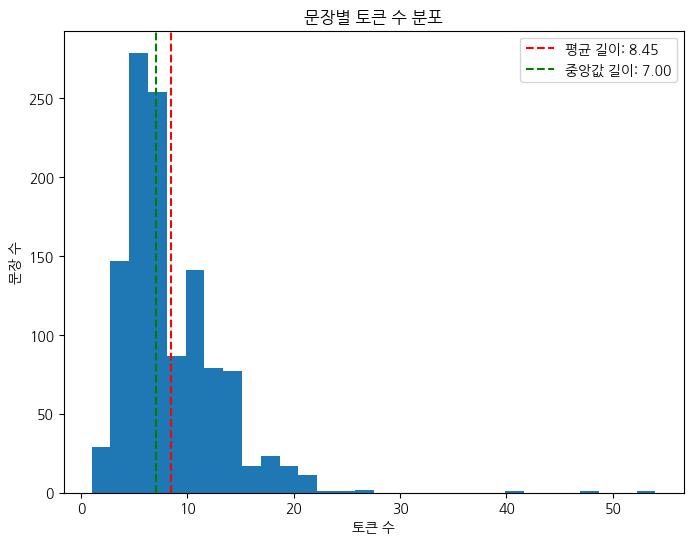

In [80]:
# 문장별 토큰 수 카운트
token_counts = [len(sentence) for sentence in x_train]

# 기초 통계량
max_len = np.max(token_counts)
min_len = np.min(token_counts)
avg_len = np.mean(token_counts)
median_len = np.median(token_counts)

print(f'최대 길이: {max_len}')
print(f'최소 길이: {min_len}')
print(f'평균 길이: {avg_len:.2f}')
print(f'중앙값 길이: {median_len}')

# 분포 그래프
plt.figure(figsize=(8, 6))
plt.hist(token_counts, bins=30)
plt.axvline(x=avg_len, color='red', linestyle='--', label=f'평균 길이: {avg_len:.2f}')
plt.axvline(x=median_len, color='green', linestyle='--', label=f'중앙값 길이: {median_len:.2f}')
plt.xlabel('토큰 수')
plt.ylabel('문장 수')
plt.title('문장별 토큰 수 분포')
plt.legend()
plt.show()

* 문장별 토큰이 가장 큰 것이 57개 입니다.

* 학습 입력을 위한 데이터 크기 맞추기
    * 문장이 짧기 때문에 MAX_SEQUENCE_LENGTH는 정하지 않아도 되지만,
    * 그러나 분포를 보고 적절하게 자릅시다.
    * 그리고 pad_sequences 함수를 이용하여 시퀀스데이터로 변환하기
* y는 train['type'] 와 test['type'] 입니다.

In [81]:
y_train = train_data_mecab['type'].values.astype(int)
y_test = test_data_mecab['type'].values.astype(int)

In [82]:
# maxlen=MAX_SEQUENCE_LENGTH: 시퀀스의 길이를 MAX_SEQUENCE_LENGTH에 맞게 설정합니다. 이를 통해 모든 시퀀스가 동일한 길이를 갖게 됩니다.
# padding='pre': 시퀀스의 앞 부분 (시작 부분)에 패딩을 추가합니다. 패딩은 시퀀스의 길이가 MAX_SEQUENCE_LENGTH보다 짧을 때 추가됩니다.
# truncating='post': 시퀀스의 뒷 부분 (끝 부분)을 자릅니다. 시퀀스가 MAX_SEQUENCE_LENGTH보다 길 경우 뒷 부분을 자립니다.

MAX_SEQUENCE_LENGTH = 10
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='post')
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='post')

#### 2) 모델링

* 토크나이징 한 데이터를 입력으로 받아
* Embedding 레이어와 LSTM 레이어를 결합하여 이진 분류 모델링을 수행합니다.

In [83]:
tf.keras.backend.clear_session()

X = Input(shape=(MAX_SEQUENCE_LENGTH, ))
H = Embedding(vocab_size, 128)(X)
H = LSTM(32, return_sequences=True)(H)
H = LSTM(32, return_sequences=False)(H)
H = Dense(1024, activation='relu')(H)
Y = Dense(1, activation='sigmoid')(H)

type_model_lstm = Model(X, Y)

type_model_lstm.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
type_model_lstm.summary()

# 모델 훈련
type_model_lstm.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 128)           151040    
                                                                 
 lstm (LSTM)                 (None, 10, 32)            20608     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1024)              33792     
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 214785 (839.00 KB)
Trainable params: 214785 (83

In [ ]:
# 예측 및 검증
y_pred = type_model_lstm.predict(x_test) # y_pred는 모델의 예측 결과를 나타내며, 이 예측 값은 연속적인(continuous) 값

# y_pred_label = (y_pred > 0.5).astype(int)
y_pred_label = np.where(y_pred < 0.5, 0, 1).flatten()
 # 임계값을 0.5로 설정, 예측 값을 이진 클래스로 변환하거나, 다중 클래스인 경우 가장 높은 예측 확률을 가진 클래스로 예측 값을 변환할 수 있습니다.
accuracy_score(y_test, y_pred_label)

#### 2) FastText 모델 생성
* FastText 문법
    * FastText( input데이터,  min_count = , size= , window=  )
        * input데이터 : 학습에 사용할 문장으로 이루어진 리스트
        * min_count : 모델에 사용할 단어의 최소 빈도수. 이 값보다 적게 출현한 단어는 모델에 포함되지 않음. 기본값 = 5
        * size : 단어의 벡터 차원 지정. 기본값 = 100
        * window : 학습할 때 한 단어의 좌우 몇 개의 단어를 보고 예측을 할 것인지를 지정. 기본값 = 5
    * 참조 : https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText

* FastText를 위한 입력 데이터 구조 만들기

In [86]:
x_train = [x.split() for x in train_data_mecab['Q']]
x_test = [x.split() for x in test_data_mecab['Q']]

* FastText 모델 생성

In [87]:
from gensim.models import FastText

ft_model = FastText(
    x_train,
    min_count=5,
    vector_size=32,       # 단어 벡터의 차원 (원하는 차원으로 설정)
    window=5,             # 포함할 단어의 최소 빈도 (1 이상의 값을 설정)
    sg=1,                 # 훈련 알고리즘 선택: 1은 skip-gram, 0은 CBOW
    )

ft_model.train(x_train, total_examples=len(x_train), epochs=10)

(52165, 107520)

In [88]:
x_train = train_data_mecab['Q'].apply(lambda x: get_sent_embedding(ft_model, 32, x))
x_test = test_data_mecab['Q'].apply(lambda x: get_sent_embedding(ft_model, 32, x))
x_train = np.array([list(x) for x in x_train])
x_test = np.array([list(x) for x in x_test])

### (3) 챗봇 구축
- input 질문
- intent classifier로 common와 faq 중 하나를 예측
- 예측된 intent에 속한 train의 모든 Q와 input 문장의 임베딩 벡터간의 코사인 유사도 계산
- 코사인 유사도가 가장 높은 top-3개의 Q를 선택
- 선택한 Q에 맵핑된 답변 중 하나를 선택하고 실제 답변과 비교

#### 1) 하나의 질문으로 테스트해보기

* 선택된 질문과 답변

In [89]:
test_input = train_data_mecab.loc[3, 'Q']
test_answer = train_data_mecab.loc[3, 'A']
test_input, test_answer

('취직 하 면 공부 안 해도 되 는 줄 알 았 는데', '공부는 끝이 없죠.')

In [90]:
temp = tk.texts_to_sequences([test_input])
temp = pad_sequences(temp, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='post')

In [115]:
type_pred = (type_model_lstm.predict(temp) > 0.5).astype(int)[0][0]
type_pred

1/1 [==============================] - 0s 19ms/step


0

In [92]:
q = tokenize('MeCab', test_input)
q = get_sent_embedding(ft_model, 32, q)

from sklearn.metrics.pairwise import cosine_similarity

answer_idx = cosine_similarity(q.reshape(1, -1), x_train).argmax()

In [93]:
temp_df = train_data_mecab[train_data_mecab['type'] == str(int(type_pred))].reset_index(drop=True)

In [94]:
q_vecs = temp_df['Q'].apply(lambda x: get_sent_embedding(ft_model, 32, x))
q_vecs = np.array([list(x) for x in q_vecs])

In [95]:
answer_idx = cosine_similarity(q.reshape(1, -1), q_vecs).argmax()
intent_pred = temp_df.loc[answer_idx, 'intent']

print(type_pred, answer_idx, intent_pred)

temp_df.loc[answer_idx, 'A'],

0 0 6


('공부는 끝이 없죠.',)


#### 2) 함수로 생성하기

In [96]:
def get_answer3(question):
    question = tokenize('MeCab', question)
    temp = tk.texts_to_sequences([question])
    temp = pad_sequences(temp, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='post')
    type_pred = (type_model_lstm.predict(temp) > 0.5).astype(int)[0][0]
    temp_df = train_data_mecab[train_data_mecab['type'] == str(int(type_pred))].reset_index(drop=True)

    q = tokenize('MeCab', question)
    q = get_sent_embedding(ft_model, 32, q)
    q_vecs = temp_df['Q'].apply(lambda x: get_sent_embedding(ft_model, 32, x))
    q_vecs = np.array([list(x) for x in q_vecs])
    answer_idx = cosine_similarity(q.reshape(1, -1), q_vecs).argmax()
    intent_pred = temp_df.loc[answer_idx, 'intent']

    return temp_df.loc[answer_idx, 'A'], intent_pred

In [97]:
print(get_answer3('다른 교육과의 차이점'))

1/1 [==============================] - 0s 19ms/step
('KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무에서 일하는 방식을 배울 수 있습니다. 또한, KT 현직 전문가가 전담하여 산업지식, AI/DX 기술, 창의성을 갖출 수 있도록 강의와 코칭을 제공하고, 강의 중 궁금한 사항은 전담 튜터가 1:10로 직접 코칭을 제공합니다. 특히, 우수 수료생을 대상으로 KT와 KT 그룹, AI원팀, 협력사 등 채용까지 연계해 드립니다.', 53)


In [98]:
print(get_answer3('노트북의 사양이 어떻게 되나요?'))

1/1 [==============================] - 0s 34ms/step
('학교 사정으로 졸업예정증명서 발급이 불가능한 경우 수료증명서 또는 재학증명서를 제출하여 주시기 바라며, 추후 졸업예정증명서 발급 가능 시점에 제출 요청을 드릴 수 있습니다.\n대학원 재학 중으로 성적증명서가 없으신 경우, 최종학력은 대학교로 입력하여 주시고 졸업(예정)증명서 및 성적증명서 제출란에는 재학증명서를 제출하여 주시기 바랍니다.\n국외 대학의 경우, 졸업을 확인할 수 있는 서류인 공식 졸업장(예: Diploma)과, 4년간의 이수 과목과 성적을 확인할 수 있는 성적표(예: Transcript)를 제출하시면 됩니다.', 39)


In [99]:
print(get_answer3('재직자도 지원 가능한가요?'))

1/1 [==============================] - 0s 26ms/step
('KT 에이블스쿨은 미취업자를 대상으로 하며, 교육 시작일 기준 재직자는 지원이 불가능합니다.\n미취업자의 기준은 아래와 같습니다.\n1) 기간의 정함이 있는 근로인 경우\n2) 고용보험에 미가입한 경우\n3) 고용보험에 가입되어 있더라도 15시간/주 미만 근로인 경우\n단, 어떠한 경우에도 교육을 풀타임(09:00~18:00)으로 들을 수 있어야 교육 참여가 가능합니다. \n\n프리랜서 계약의 경우, 고용보험에 가입하지 않은 경우 미취업자로 보지만, 개인별 상황이 다를 수 있어서 관할 고용센터에 문의하여 확인하시기 바랍니다. \n또한 현재 군 복무 중인 상태여도 지원 가능하며, 교육 시작 전일까지 병역 의무를 마쳐야 교육 수강이 가능합니다. \n\n퇴사 후 고용보험 상실이 완료되어 실업급여를 수급 중인 경우, 훈련 수강에는 문제가 없습니다.\n다만, 실업급여와 훈련장려금은 중복 수급이 불가하여 실업급여 지급이 종료된 후 훈련장려금 지급이 개시됩니다.', 32)


In [104]:
print(get_answer3('너무 힘들어요'))

1/1 [==============================] - 0s 21ms/step
('많이 만나보세요.', 19)


In [105]:
print(get_answer3('배가고파요'))

1/1 [==============================] - 0s 20ms/step
('여유를 가지세요.', 24)


In [106]:
print(get_answer3('기숙사 제공이 되나요?'))

1/1 [==============================] - 0s 19ms/step
('학교 사정으로 졸업예정증명서 발급이 불가능한 경우 수료증명서 또는 재학증명서를 제출하여 주시기 바라며, 추후 졸업예정증명서 발급 가능 시점에 제출 요청을 드릴 수 있습니다.\n대학원 재학 중으로 성적증명서가 없으신 경우, 최종학력은 대학교로 입력하여 주시고 졸업(예정)증명서 및 성적증명서 제출란에는 재학증명서를 제출하여 주시기 바랍니다.\n국외 대학의 경우, 졸업을 확인할 수 있는 서류인 공식 졸업장(예: Diploma)과, 4년간의 이수 과목과 성적을 확인할 수 있는 성적표(예: Transcript)를 제출하시면 됩니다.', 39)


In [ ]:
print(get_answer3('기숙사 제공이 되나요?'))

In [101]:
y_pred = [get_answer3(x)[1] for x in test_data_mecab['Q']]
accuracy_score(test_data_mecab['intent'].values, y_pred)

1/1 [==============================] - 0s 26ms/step


0.2923076923076923

## 5.질문에 대한 답변 비교해보기

* **세부요구사항**
    * 세가지 챗봇을 생성해 보았습니다.
    * 질문을 입력하여 답변을 비교해 봅시다. 어떤 챗봇이 좀 더 정확한 답변을 하나요?


In [153]:
질문 = '기숙사 제공이 되나요?'
print("="*200)
print("질문 :", 질문)
print('챗봇1 답변 :')
print(get_answer1(질문))
print('')
print("="*200)
print('챗봇2 답변 :')
print(get_answer2(질문))
print('')
print("="*200)
print('챗봇3 답변 :')
print(get_answer3(질문))

질문 : 기숙사 제공이 되나요?
챗봇1 답변 :
['KT 에이블스쿨은 고용노동부 K-Digital Training 사업으로 운영됨에 따라 총 훈련일수의 80% 이상을 출석한 경우 수료대상이 됩니다.\n반대로, 총 훈련일수의 20%를 초과하여 결석한 경우 제적대상이 됩니다.']

챗봇2 답변 :
('교육기간 동안 노트북을 무료로 지원하며, 교육에 필요한 필수 프로그램이 설치되어 있으므로, 제공한 노트북을 사용해 주시기 바랍니다.\n\n원활한 실습 환경을 위해 아래 명시된 사양 이상을 갖춘 노트북을 제공합니다. \n- CPU : I5 / RAM : 8GB / 여유저장공간 : 40GB', 46)

챗봇3 답변 :
1/1 [==============================] - 0s 43ms/step
('학교 사정으로 졸업예정증명서 발급이 불가능한 경우 수료증명서 또는 재학증명서를 제출하여 주시기 바라며, 추후 졸업예정증명서 발급 가능 시점에 제출 요청을 드릴 수 있습니다.\n대학원 재학 중으로 성적증명서가 없으신 경우, 최종학력은 대학교로 입력하여 주시고 졸업(예정)증명서 및 성적증명서 제출란에는 재학증명서를 제출하여 주시기 바랍니다.\n국외 대학의 경우, 졸업을 확인할 수 있는 서류인 공식 졸업장(예: Diploma)과, 4년간의 이수 과목과 성적을 확인할 수 있는 성적표(예: Transcript)를 제출하시면 됩니다.', 39)


In [154]:
질문 = '노트북 사양이 어떻게 되나요??'
print("질문 :", 질문)
print('챗봇1 답변 :')
print(get_answer1(질문))
print('')
print("="*50)
print('챗봇2 답변 :')
print(get_answer2(질문))
print('')
print("="*50)
print('챗봇3 답변 :')
print(get_answer3(질문))

질문 : 노트북 사양이 어떻게 되나요??
챗봇1 답변 :
['직장 스트레스 심하겠네요.']

챗봇2 답변 :
('교육기간 동안 노트북을 무료로 지원하며, 교육에 필요한 필수 프로그램이 설치되어 있으므로, 제공한 노트북을 사용해 주시기 바랍니다.\n\n원활한 실습 환경을 위해 아래 명시된 사양 이상을 갖춘 노트북을 제공합니다. \n- CPU : I5 / RAM : 8GB / 여유저장공간 : 40GB', 46)

챗봇3 답변 :
1/1 [==============================] - 0s 19ms/step
('학교 사정으로 졸업예정증명서 발급이 불가능한 경우 수료증명서 또는 재학증명서를 제출하여 주시기 바라며, 추후 졸업예정증명서 발급 가능 시점에 제출 요청을 드릴 수 있습니다.\n대학원 재학 중으로 성적증명서가 없으신 경우, 최종학력은 대학교로 입력하여 주시고 졸업(예정)증명서 및 성적증명서 제출란에는 재학증명서를 제출하여 주시기 바랍니다.\n국외 대학의 경우, 졸업을 확인할 수 있는 서류인 공식 졸업장(예: Diploma)과, 4년간의 이수 과목과 성적을 확인할 수 있는 성적표(예: Transcript)를 제출하시면 됩니다.', 39)


In [155]:
질문 = '배가 고픕니다'
print("질문 :", 질문)
print('챗봇1 답변 :')
print(get_answer1(질문))
print('')
print("="*50)
print('챗봇2 답변 :')
print(get_answer2(질문))
print('')
print("="*50)
print('챗봇3 답변 :')
print(get_answer3(질문))

질문 : 배가 고픕니다
챗봇1 답변 :
['다녀오세요. 기다릴게요.']

챗봇2 답변 :
('저도요!', 27)

챗봇3 답변 :
1/1 [==============================] - 0s 20ms/step
('좋은 생각이에요.', 29)


In [156]:
질문 = '취업하면 공부 안해도 될 줄 알았는데'
print("질문 :", 질문)
print('챗봇1 답변 :')
print(get_answer1(질문))
print('')
print("="*50)
print('챗봇2 답변 :')
print(get_answer2(질문))
print('')
print("="*50)
print('챗봇3 답변 :')
print(get_answer3(질문))

질문 : 취업하면 공부 안해도 될 줄 알았는데
챗봇1 답변 :
['공부가 최우선이죠.']

챗봇2 답변 :
('공부는 끝이 없죠.', 6)

챗봇3 답변 :
1/1 [==============================] - 0s 19ms/step
('공부는 끝이 없죠.', 6)


In [157]:
질문 = '에이블스쿨을 소개해주세요'
print("질문 :", 질문)
print('챗봇1 답변 :')
print(get_answer1(질문))
print('')
print("="*50)
print('챗봇2 답변 :')
print(get_answer2(질문))
print('')
print("="*50)
print('챗봇3 답변 :')
print(get_answer3(질문))

질문 : 에이블스쿨을 소개해주세요
챗봇1 답변 :
['축하드려요']

챗봇2 답변 :
('KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n전공은 상관 없습니다.', 31)

챗봇3 답변 :
1/1 [==============================] - 0s 38ms/step
('노력하겠습니다.', 12)


In [158]:
질문 = '다른 교육과의 차이점이 뭐죠?'
print("질문 :", 질문)
print('챗봇1 답변 :')
print(get_answer1(질문))
print('')
print("="*50)
print('챗봇2 답변 :')
print(get_answer2(질문))
print('')
print("="*50)
print('챗봇3 답변 :')
print(get_answer3(질문))

질문 : 다른 교육과의 차이점이 뭐죠?
챗봇1 답변 :
['KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무에서 일하는 방식을 배울 수 있습니다. 또한, KT 현직 전문가가 전담하여 산업지식, AI/DX 기술, 창의성을 갖출 수 있도록 강의와 코칭을 제공하고, 강의 중 궁금한 사항은 전담 튜터가 1:9로 직접 코칭을 제공합니다. 특히, 우수 수료생을 대상으로 KT와 KT 그룹, AI원팀, 협력사 등 채용까지 연계해 드립니다.']

챗봇2 답변 :
('KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무에서 일하는 방식을 배울 수 있습니다. 또한, KT 현직 전문가가 전담하여 산업지식, AI/DX 기술, 창의성을 갖출 수 있도록 강의와 코칭을 제공하고, 강의 중 궁금한 사항은 전담 튜터가 1:4로 직접 코칭을 제공합니다. 특히, 우수 수료생을 대상으로 KT와 KT 그룹, AI원팀, 협력사 등 채용까지 연계해 드립니다.', 53)

챗봇3 답변 :
1/1 [==============================] - 0s 36ms/step
('KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무에서 일하는 방식을 배울 수 있습니다. 또한, KT 현직 전문가가 전담하여 산업지식, AI/DX 기술, 창의성을 갖출 수 있도록 강의와 코칭을 제공하고, 강의 중 궁금한 사항은 전담 튜터가 1:4로 직접 코칭을 제공합니다. 특히, 우수 수료생을 대상으로 KT와 KT 그룹, AI원팀, 협력사 등 채용까지 연계해 드립니다.', 53)
